1. refer = 1 then hosp gps 
2. sample of hospital gps - boot strap - if came from a hosp but no name 
3. random sample of the admin unit 

* select seed for randomization 
- restrict year to 2016 =<

1. mapping of patients 
2. network analysis (dependent: gps of kirtipur | road network, assigned speed limit (1st, 2nd, 3rd), place of origin, overlay topograpgy ==> time variable 
3. Dependent variable = admission condition (good vs ANY infection) 
  a. time from injury to admission
  b. travel time not distance 
  c. specific places (hosp) proportions of patients admitted in poor condition vs admitted in fine condition 
   - any problems --> poor 
  d. days treated at another - Are patient inapprop held 
  e. sweet spot of pre transfer time (burn size, area of burned) - data driven 
4. After Jan
  a. location allocation model

In [0]:
# All of the packages that need to be downloaded
%%capture
!pip install overpy
!pip install geojson
!pip install geojsonio
!pip install openrouteservice
!pip install geopandas
!pip install plotly==4.3.0
#!pip install fuzzywuzzy
#!pip install python-Levenshtein
!pip install fuzzyset
!pip install arcgis
!pip install rasterio
!pip install GDAL
#!easy_install Rtree
#!pip install georasters
!pip install -U googlemaps

In [0]:
import os 
import re
from datetime import datetime
import json
#from fuzzywuzzy import fuzz, process
import fuzzyset
from datetime import datetime, timedelta
import numpy as np
import pandas as pd # data import and maniplation 
import seaborn as sns
import matplotlib.pyplot as plt # data visualization 
import plotly.offline as py
import plotly.graph_objects as go

# geospatial packages
import overpy 
#import geojson
import geojsonio
from geojson import Feature, FeatureCollection, Point
import openrouteservice
import geopandas
import gdal
import rasterio
import rasterio.plot
import googlemaps
#import georasters as gr
#from arcgis.geoenrichment import *
#from arcgis.gis import GIS

from sklearn import datasets, linear_model # regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # data split 
from random import randint
import fiona

sns.set_style("whitegrid")
api = overpy.Overpass()

In [97]:
# if I want to change between google collab or spyder 
if True:
    from google.colab import files
    files.upload()    

Saving Nepal_Validation - Sheet1.csv to Nepal_Validation - Sheet1.csv


In [0]:
# data input
df = pd.read_excel('Nepal Cumulative Burns 2014-19 copy.xlsx')
hosp_df = pd.read_csv('Nepal_Validation - Sheet1.csv')
df = df[df['Year'] != 2014]

# removes duplicate
df['Program'] = df['Program'].apply(lambda x: str(x).lower().strip().replace('silf', 'self').replace('wonder work', 'ww').replace('wonderwork', 'ww').replace('sef', 'self').replace('selff', 'self').replace('self1', 'self'))

# gives a patient number proxy 
#df['patient'] = np.arange(len(df))
df['Name of Hospital'] = df['Name of Hospital'].apply(lambda x: x if str(x) == 'nan'  else str(x).strip().lower())
df = df.sort_values( 'Name of Hospital', ascending = True).reset_index()
df['Hosp_true_name'] = hosp_df['OSM']
#df['hosp_cor_gps'] = hosp_df['hosp_corre'].apply(lambda x: "" if str(x) == 'nan'  else  str(x).split(','))


# importing geojson from overpressturbo, formatting
nepal_map = geopandas.read_file("export.geojson")
nepal_map['name:en'] = nepal_map['name:en'].apply(lambda x: str(x).lower().replace('sindhupalchowk', 'sindhupalchok'))
nepal_map['id'] = np.arange(len(nepal_map))

In [114]:
[ i for i in enumerate(hosp_df)]

[(0, 'Address'),
 (1, 'Hospital Name change'),
 (2, 'Name of Hospital'),
 (3, 'OSM'),
 (4, 'Unnamed: 4'),
 (5, 'Unnamed: 5'),
 (6, 'Unnamed: 6'),
 (7, 'hosp_corr_lat'),
 (8, 'hosp_corr_lon'),
 (9, 'Unnamed: 9'),
 (10, 'Unnamed: 10'),
 (11, 'Unnamed: 11'),
 (12, 'Unnamed: 12'),
 (13, 'Unnamed: 13')]

In [115]:
hosp_df

,Address,Hospital Name change,Name of Hospital,OSM,Unnamed: 4,Unnamed: 5,Unnamed: 6,hosp_corr_lat,hosp_corr_lon,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,dhoti,Acham Hospital,Acham Hospital,NaN,NaN,NaN,NaN,29.134940,81.256227,Acham Hospital,Acham Hospital,29.134940,81.256227,"29.1349404,81.2562267"
1,birjung,Advanced Hospital,Advanced Hospital,NaN,NaN,NaN,NaN,27.007473,84.871513,Advanced Hospital,Advanced Hospital,27.007473,84.871513,"27.0074727,84.8715133"
2,bhaktapur,Akla Hospital,Akla Hospital,Alka Hospital,NaN,NaN,NaN,NaN,NaN,AMS Hospital,AMS Hospital,27.063552,85.751080,"27.0635523,85.7510803"
3,kavrepalanchok,Alka Hospital,Alka Hospital,Alka Hospital,NaN,NaN,NaN,NaN,NaN,Bara Hospital,Bara Hospital,27.028072,84.999633,"27.028072,84.9996332"
4,kathmandu,Alka Hospital,Alka Hospital,Alka Hospital,NaN,NaN,NaN,NaN,NaN,Barahi hospital,Barahi hospital,28.215074,83.977403,"28.2150742,83.9774028"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,paesa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2098,baglung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2099,jajarkot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Geocoding:

Open steet map 
https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative#10_admin_level_values_for_specific_countries

Admin level:
- 3: Province
- 4: Dev Region
- 5: Zones
- 6: Districts
- 7: Municipalities 
- 8 Cities/Villages

# Overpass/OSM queries

In [0]:
# DISTRICT query 
# This is where you can call the tags for the particular id then get the meta data 
# result.relations[1].tags, gets the center lat for the relation 

district = api.query("""
[out:json];
area["ISO3166-1"="NP"][admin_level = 2]->.boundaryarea;  
(
  rel(area..boundaryarea)[admin_level="6"];
);
out center meta;""")

district_map = {}
error = 0
for rel in district.relations:
  if (rel.tags.get('name:en', "empty") != 'empty'):
    district_map[rel.tags['name:en'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  elif (rel.tags.get('name', "empty") != 'empty'):
    district_map[rel.tags['name'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  else: 
    district_map[error] = rel
    error += 1
district_map.pop('error', None)

In [0]:
# gets all villages in Nepal
villages = api.query("""
[out:json];
area["ISO3166-1"="NP"][admin_level = 2]->.boundaryarea;  
(
  rel(area..boundaryarea)[admin_level="8"]; 
);
out center meta;
""")

village_map = {}
error = 0
for rel in villages.relations:
  if (rel.tags.get('name:en', "empty") != 'empty'):
    village_map[rel.tags['name:en'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  elif (rel.tags.get('name', "empty") != 'empty'):
    village_map[rel.tags['name'].lower()] = [float(rel.center_lon),float(rel.center_lat)]
  else: 
    village_map[error] = rel
    error += 1
village_map.pop('error', None)

# Formatting address and district naming

In [0]:
# Processes the formatting and spelling of addresses
df['Address'] = df['Address'].apply(lambda x: str(x).lower().strip().replace('ktm', 'kathmandu').replace('accham', 'achham').replace('agrakhanchi', 'arghakhanchi').replace('argakhachi', 'arghakhanchi').replace('argakhanchi', 'arghakhanchi').replace('arghakhachi', 'arghakhanchi').replace('baglong', 'baglung').replace('bajhang', 'bajang').replace('bhairawa', 'bhairahawa').replace('bharatpur','bhaktapur').replace('bhkatapur','bhaktapur').replace('butuwal','butwal').replace('bajang','bajhang').replace('chayanpur','chainpur').replace('dailekha','dailekh').replace('dhangadi','dhangari').replace('dhanusa','dhanusha').replace('dhanushaa','dhanusha').replace('dhulekhel','dhulikhel').replace('dolakaha','dolakha').replace('dolkaha','dolakha').replace('illam','ilam').replace('ithari','itahari').replace('ittahari','itahari').replace('kapilbastu','kapilvastu').replace('kavrepalanchowk','kavrepalanchok').replace('kavre','kavrepalanchok').replace('kirtipipur','kirtipur').replace('kohalpir','kohalpur').replace('kuleshor','kuleshwor').replace('lamgunj','lamjung').replace('llitpur','lalitpur').replace('mahatori','mahottari').replace('mahatari','mahottari').replace('mahotari','mahottari').replace('makawanpur','makwanpur').replace('nawalparashi','nawalparasi').replace('nawalparasi','nawalparasi').replace('nepaljung','nepalgunj').replace('okahaldhunga','okhaldhunga').replace('okaldhunga','okhaldhunga').replace('parsha','parsa').replace('pokahara','pokhara').replace('ramechap','ramechhap').replace('samkhuwasabha','sankhuwasabha').replace('sankhuwasava','sankhuwasabha').replace('sakhawasaba','sankhuwasabha').replace('sangjhya','sanghiya').replace('saralahi','sarlahi').replace('shankhuwashabha','sankhuwasabha').replace('shyanja','shyangja').replace('simra','simara').replace('simra','simara').replace('sindhui','sindhuli').replace('sindhupalchowk','sindhupalchok').replace('sinduli','sindhuli').replace('sindupalchok','sindhupalchok').replace('sindupalchowk','sindhupalchok').replace('snkhuwasabha','sankhuwasabha').replace('syanja','syangja').replace('syanjha','syangja').replace('tanahu','tanahun').replace('taplegunj','taplejung').replace('taudhaha','taudaha').replace('terathum','tehrathum').replace('udaypur','udayapur'))
df['Address2'] = df['Address'].apply(lambda x: str(x).lower().strip().replace(', ', ',').replace('- ', '-').split(','))

# extracts district and village from the query / shapefile
df['district'] = df['Address2'].apply(lambda x: [y for y in x if y in list(nepal_map['name:en'].unique())]).apply(lambda x: x[0] if x != [] else '')
df['village']  = df['Address2'].apply(lambda x: [y for y in x if y in list(village_map.keys())]).apply(lambda x: x[0] if x != [] else '')
df['district_gps'] = df['district'].apply(lambda x: district_map[x] if x in district_map.keys() else '')
df['village_gps']  = df['village'].apply(lambda x: village_map[x] if x in village_map.keys() else '')

In [0]:
# Noting the amount of noted hosp and matching names for district and village 
df[(df['village'] != '') & (df['district'] != '') & ~(df['Name of Hospital'].isna())]
#(df['Name of Hospital'].apply(lambda x: str(x).lower())).unique()

,index,S NO,Year,Program,Age (yrs),Male,Female,Address,Baux Score,ABSI,Flame,Lightning,Scald,Electrical,Acid,Alkali,Steam,Contact,Others,incident inside house,At cooking place,incident outside house,At work,Suicide,Homicide,Date /Time of burn injury,Time of Burn,Date/Time of admission,Time of Admission,Time Elapsed,Date of Discharge,ALL Total Hosp Stay,Mortality,cause of death/day of death(post burn),Date of Death,Post burn Day of Death,weight at admission,weight at discharge,Weight Loss,Total days in ICU,...,MRSA.2,MDR.2,3RD C/S,date.1,Organism.4,Sensitivec,Resistance.3,MRSA.3,MDR.3,4RD C/S,Date.6,Organism.5,Sensitive.3,Resistance.4,MRSA.4,MDR.4,5RD C/S,Date.7,Organism.6,Sensitive.4,Resistance.5,6RD C/S,Date.8,Organism.7,Sensitive.5,Resistance.6,7RD C/S,Date.9,Organism.8,Sensitive.6,Resistance.7,LAMA.1,DOR,Septic shock,Hosp_true_name,Address2,district,village,district_gps,village_gps
2,1092,432,2017,risop,1,1,NaN,bhaktapur,6,3,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,18.11.2017,NaN,18.11.2017,NaN,0,26.11.2017,8,NaN,NaN,NaN,NaN,10.5,11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alka Hospital,[bhaktapur],bhaktapur,bhaktapur,"[85.4384216, 27.6742108]","[85.4243527, 27.6777964]"
5,1158,2,2018,self,2,1,NaN,kathmandu,8,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,2.1.2018,NaN,2.1.2018,NaN,0,8.1.2018,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alka Hospital,[kathmandu],kathmandu,kathmandu,"[85.3770973, 27.6940775]","[85.3218318, 27.7096445]"
10,370,83,2016,nan,36,NaN,1.0,kathmandu,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,13.2.2016,NaN,13.2.2016,NaN,0,2.4.2016,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alka Hospital,[kathmandu],kathmandu,kathmandu,"[85.3770973, 27.6940775]","[85.3218318, 27.7096445]"
16,792,132,2017,risop,60,NaN,1.0,gorkha,87,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,26.3.2017,NaN,27.3.2017,NaN,1,21.4.2017,24,NaN,NaN,NaN,NaN,45,44,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nepal A.P.F. Hospital,[gorkha],gorkha,gorkha,"[84.8082601, 28.2735626]","[84.6118232, 27.9924068]"
17,1846,82,2019,self,49,1,NaN,kathmandu,57,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,30.1.2019,5.30am,30.1.2019,NaN,0,15.2.2019,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nepal A.P.F. Hospital,[kathmandu],kathmandu,kathmandu,"[85.3770973, 27.6940775]","[85.3218318, 27.7096445]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,541,254,2016,nan,25,NaN,1.0,kathmandu,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,(chemical burn-bromine),NaN,NaN,1.0,1.0,NaN,NaN,2.8.2016,NaN,4.8.2016,NaN,2,13.9.2016,9,NaN,NaN,NaN,NaN,61,NaN,NaN,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vayodha Hospital,[kathmandu],kathmandu,kathmandu,"[85.3770973, 27.6940775]","[85.3218318, 27.7096445]"
1167,1436,280,2018,self,50,NaN,1.0,baglung,70,7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,30.1.2018,NaN,29.4.2018,NaN,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# Merging gps with location data

In [0]:
# district/village df are in an odd data format 
# turning both into a df  
df_distmap = pd.Series(district_map, name = 'dist_map')
df_distmap.index.name = 'district'
df_distmap = df_distmap.reset_index()

df_villmap = pd.Series(village_map, name = 'vill_map')
df_villmap.index.name = 'village'
df_villmap = df_villmap.reset_index()

In [0]:
# Creating a column of patient counters  
# * Gotta convert to df first before anything or else python thinks its a relation 
nepal_map = nepal_map.merge(pd.DataFrame(df.groupby(['district'])['district'].size().reset_index(name='counts'))[1:], how ='left' , left_on = 'name:en', right_on = 'district')
nepal_map[['counts']] = nepal_map[['counts']].fillna(value = 0)

vill_merge = pd.DataFrame( df.groupby(['village'])['village'].size().reset_index(name='counts') )[1:].merge(df_villmap, how ='left', on = 'village' )
vill_merge['long'] = vill_merge['vill_map'].apply(lambda x: x[0])
vill_merge['lat'] = vill_merge['vill_map'].apply(lambda x: x[1])

# Converting the city coords into a geopandas data df
nepal_cities = geopandas.GeoDataFrame(vill_merge, geometry=geopandas.points_from_xy(vill_merge.long, vill_merge.lat))
#dist_merge = df[df['village'] == ''][['patient','district']].merge(df_distmap, on = 'district' )
#vill_merge = df[df['district'] == ''][['patient','village']].merge(df_villmap, on = 'village' )

# Issue 

Matching is not quite there but wit the implementation of the fuzzy set it does help a lot 
- additional is to also set the option that has the first letter as the same 

In [0]:
df[['Address', 'Name of Hospital', 'Address2', 'district', 'village']]

,Address,Name of Hospital,Address2,district,village
90,kathmandu,NaN,[kathmandu],kathmandu,kathmandu
91,lamjung,NaN,[lamjung],lamjung,
92,morang,NaN,[morang],morang,
93,rautahat,NaN,[rautahat],rautahat,rautahat
94,okhaldhunga,NaN,[okhaldhunga],okhaldhunga,
...,...,...,...,...,...
2096,bara,Narayani Hospital,[bara],bara,
2097,rauthat,International society for medical education,[rauthat],,
2098,parsa,Narayan Hospital,[parsa],parsa,parsa
2099,lalitpur,NaN,[lalitpur],lalitpur,


In [0]:
df[~df['Name of Hospital'].isna()][['Address','Name of Hospital']]

,Address,Name of Hospital
307,bhaktapur,KMC
327,jajarkot,Bheri Hospital
338,sindhupalchok,Bir Hospital
346,pyuthan,Local Hospital
352,sarlahi,Teaching Hospital
...,...,...
2092,jajarkot,Nepalgung medical collage teaching hospital
2096,bara,Narayani Hospital
2097,rauthat,International society for medical education
2098,parsa,Narayan Hospital


In [0]:
df['extract_dist'] = df['Address'].apply(lambda x: process.extractOne(x, list(df_distmap['district'])))
df['extract_vill'] = df['Address'].apply(lambda x: process.extractOne(x, list(df_villmap['village'])))

In [0]:
a = fuzzyset.FuzzySet()
for i in list(df_distmap['district'].unique()):
  a.add(i)

In [0]:
b = fuzzyset.FuzzySet()
for i in list(df_villmap['village'].unique()):
  b.add(str(i))

In [0]:
df['extract_dist'] = df['Address'].apply(lambda x: a.get(x))
df['extract_vill'] = df['Address'].apply(lambda x: b.get(x))

In [0]:
df[['Address','Address2',	'district',	'village',	'extract_dist',	'extract_vill']].to_csv('df_geo.csv')

In [0]:
df_distmap.to_csv('dist_map.csv')

# Nepal Map - Visuals

## plt - skip

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


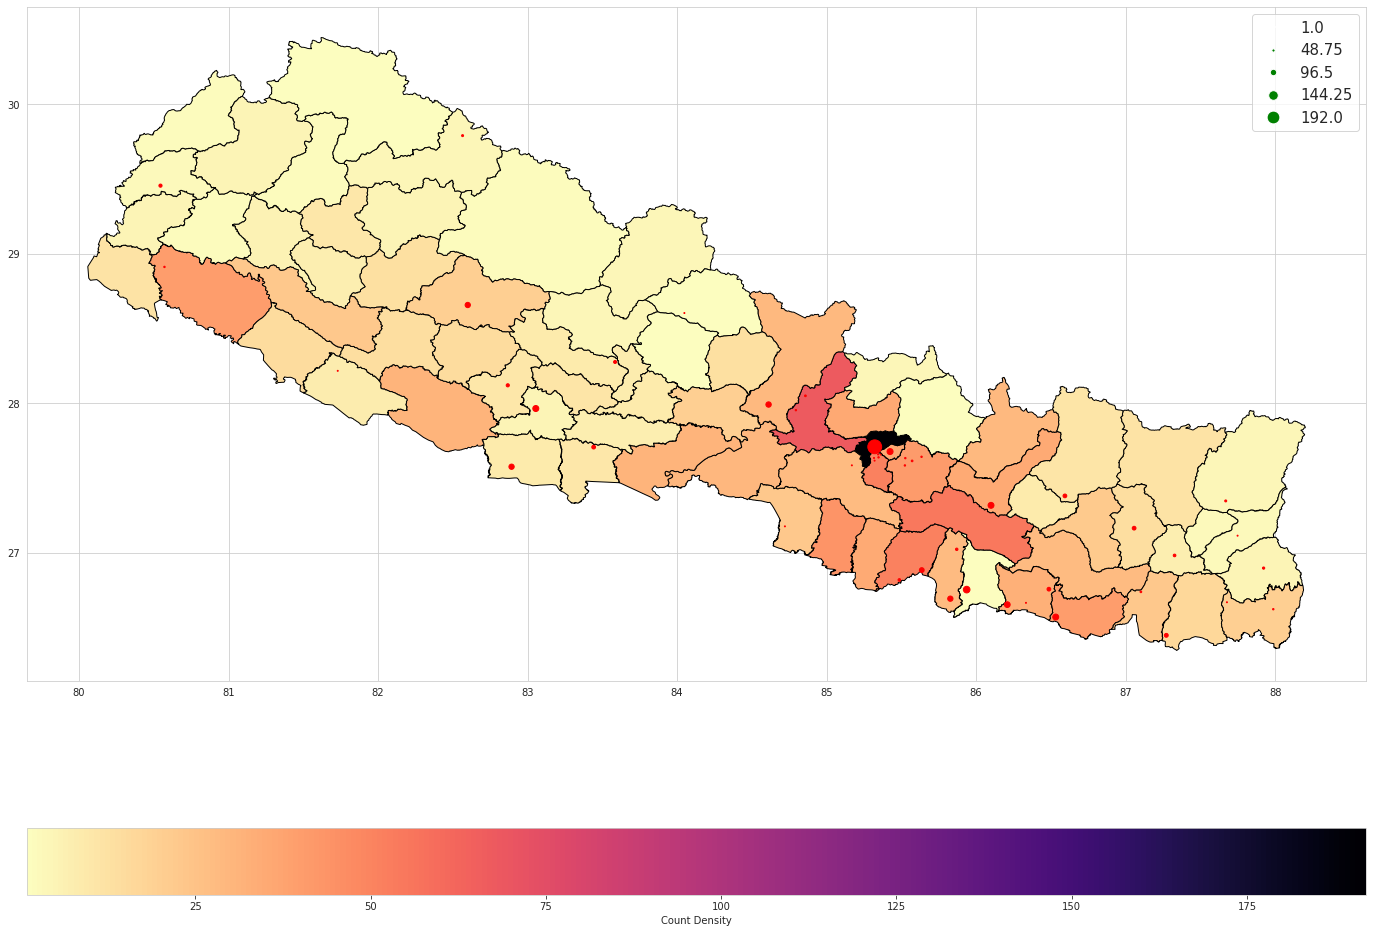

In [0]:
from matplotlib.lines import Line2D

f, ax = plt.subplots(1, figsize=(24, 18))
cmap_reversed  = plt.cm.get_cmap('magma_r')
# district grid 
ax = nepal_map[~nepal_map['admin_level'].isna()].plot(column =  'counts',
                                                      ax=ax, alpha = 1.0,
                                                      cmap=cmap_reversed, 
                                                      edgecolor='black',
                                                      legend = True,
                                                      legend_kwds={'orientation': "horizontal", 'label':'Count Density'})

# legend works, but it isnt that accurate 
legend_elements = [ Line2D([0], [0], marker='o', color='w', label= bins[i],  markerfacecolor='g', markersize=bins[i]/15)  for i in range(len(bins))   ]

# points for cities in nepal
test = nepal_cities.plot(ax=ax, color='red', markersize = nepal_cities['counts'])
ax.legend(handles = legend_elements , loc = 'upper right', prop={'size': 15})
mplcursors.cursor(hover = True)
plt.show()

## [Current] plotly

remaking map in plotly
https://plot.ly/~jackp/18273.embed

plotly works like building each layer on top of each other or modifying each other based on the function

In [0]:
# creating an overall layout template to apply to any furture attempts

lon1, lat1, lon2, lat2 = 79.4388,25.9092,88.7003,30.9781
layout = dict(
    hovermode = 'closest',
    mapbox = dict(
              style="carto-positron",
              zoom=6,
              center = dict(lat = 28.3949,
                            lon = 84.1240)),
    margin = dict(
        t=20,
        b=20,
        r=20,
        l=20
    ),
    width = 1100,
    height = 650,
    dragmode = 'zoom'
)

### First attempt - Pass

First attempt at making a interactable geodata plot 

Works but because it has to iteratively create the boundaries it is very poor when trying to create overall data metrics and only can't do color map without a lot of extra steps as I have to make the color to a particular value

In [0]:

plot_data = []
for index,row in nepal_map.iterrows():
    if nepal_map['geometry'][index].type == 'Polygon':
        x,y = np.asarray(row.geometry.exterior.xy)
        c_x,c_y = np.asarray(row.geometry.centroid.xy)
    elif nepal_map['geometry'][index].type == 'MultiPolygon':
        x = [poly.exterior.xy[0] for poly in nepal_map['geometry'][index]]
        y = [poly.exterior.xy[1] for poly in nepal_map['geometry'][index]]
        x_c = [poly.centroid.xy[0] for poly in nepal_map['geometry'][index]]
        y_c = [poly.centroid.xy[1] for poly in nepal_map['geometry'][index]]        
    else: 
        print('')
    county_outline = dict(
            type = 'scatter',
            showlegend = False,
            legendgroup = "shapes",
            line = dict(color='black', width=1),
            x=x,
            y=y,
            fill='toself',
            hoverinfo='none',
            fillcolor = 'purple'
    )
    hover_point = dict(
            type = 'scatter',
            showlegend = False,
            legendgroup = "centroids",
            text = row['name:en'],
            marker = dict(size=2),
            x=c_x,
            y=c_y,
            fill='toself',
            fillcolor = 'purple',
            hoverinfo  = 'text',
            hoverlabel = dict(bgcolor = 'white')
    )
    plot_data.append(county_outline)
    plot_data.append(hover_point)

In [0]:
fig = dict(data=plot_data, layout=layout)
py.iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

### Current attempt 

Using choroplethmapbox which allows for a full build of the map without having to manual creation 

In [0]:
# Converts the geodata into a json & fills in any empty values as a 0 count
nepal_map_json = json.loads(nepal_map[nepal_map.geometry.type == 'Polygon'].to_json())
nepal_map_json['features'][0]['id'] = 90
if len(nepal_map[nepal_map['id'] == 0]) != 0:
  nepal_map['id'][0] = 90

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
vill_merge.head()

,village,counts,vill_map,long,lat,geometry
0,baglung,9,"[83.5851655, 28.2770405]",83.585166,28.277040,POINT (83.58517 28.27704)
1,banepa,2,"[85.5263945, 27.6339678]",85.526394,27.633968,POINT (85.52639 27.63397)
2,bardibas,6,"[85.8702579, 27.0241083]",85.870258,27.024108,POINT (85.87026 27.02411)
3,bhaktapur,36,"[85.4243527, 27.6777964]",85.424353,27.677796,POINT (85.42435 27.67780)
4,bhojpur,14,"[87.0567205, 27.1654605]",87.056720,27.165460,POINT (87.05672 27.16546)


In [0]:
# Creation of the mapbox with the first layer being the district then adding each layer on top 
# Adds an underlying map 
# Adds a scatter plot of the villages based on the size of the count 
fig = go.Figure(go.Choroplethmapbox(geojson=nepal_map_json, locations = nepal_map.id, z = nepal_map.counts,
                                    colorscale="magma",
                                    reversescale=True,
                                    marker_opacity=0.5, marker_line_width=1, 
                                    below = 'traces',
                                    hoverinfo = 'text+z',
                                    hovertext = nepal_map['name:en']))
fig.update_layout(layout)
fig.add_trace(go.Scattermapbox(
                  lat = vill_merge.lat,
                  lon = vill_merge.long,
                  mode = 'markers',
                  below = "",
                  hoverinfo = 'text',
                  hovertext = vill_merge.village + ': ' + (vill_merge.counts).astype(str) ,
                  marker=go.scattermapbox.Marker(
                    #size=vill_merge.counts/7, coming back to this as it breaks with KTM 
                    size=6,
                    color='rgb(0,206,209)',
                    opacity=1.0
                  )
              ))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
py.plot(fig, 'nepal.html')

'temp-plot.html'

## ArcGIS

Geoenrichment doesn't have Nepal 
https://doc.arcgis.com/en/arcgis-online/reference/geoenrichment-coverage.htm

## Population grid

In [0]:
with rasterio.open('npl_ppp_2016.tif') as src:
    for i, dtype, nodataval in zip(src.indexes, src.dtypes, src.nodatavals):
      print(i, dtype, nodataval)
from osgeo import gdal
ds = gdal.Open('npl_ppp_2017.tif')
output = gdal.Translate('output.tif', ds, width=2024, scaleParams= [[0,12,0,255]],outputType =gdal.GDT_Byte)
output = gdal.DEMProcessing('output.tif', output, processing= 'color-relief')
output = output.ReadAsArray()

gdal.Info(ds)

fig, ax = plt.subplots(figsize=(40, 40))
plt.imshow(output)

# Hospital name merge

In [0]:
# Gets all healthcare/clinics in nepal
result = api.query("""
[out:json];
area["ISO3166-1"="NP"][admin_level = 2]->.boundaryarea;  
(
  node(area..boundaryarea)[amenity ='clinic'];
  node(area..boundaryarea)[amenity ='hospital'];
  way(area..boundaryarea)[amenity ='hospital'];    
  way(area..boundaryarea)[building ='hospital'];
);
out center meta;
""")

In [0]:
hosp_map = {}
for way in result.ways:
  if (way.tags.get('name:en', "empty") != 'empty'):
    hosp_map[way.tags['name:en'].lower()] = [float(way.center_lon),float(way.center_lat)]
  elif (way.tags.get('name', "empty") != 'empty'):
    hosp_map[way.tags['name'].lower()] = [float(way.center_lon),float(way.center_lat)]
  else: 
    hosp_map['error'] = way
for node in result.nodes:
  if (node.tags.get('name:en', "empty") != 'empty'):
    hosp_map[node.tags['name:en'].lower()] = [float(node.lon),float(node.lat)]
  elif (node.tags.get('name', "empty") != 'empty'):
    hosp_map[node.tags['name'].lower()] = [float(node.lon),float(node.lat)]
  else: 
    hosp_map['error'] = node



In [0]:
df_hosp_map = pd.Series(hosp_map, name = 'df_hosp_map')
df_hosp_map.index.name = 'hosp'
df_hosp_map = df_hosp_map.reset_index()

c = fuzzyset.FuzzySet()
for i in list(df_hosp_map['hosp'].unique()):
  c.add(str(i))
  
df['extract_hosp'] = df['Hosp_true_name'].apply(lambda x: c.get(str(x))[0][1] if str(x) != 'nan' else '') #.to_csv('test.csv')
df['hosp_gps'] = df['extract_hosp'].apply(lambda x: hosp_map[x] if x != '' else  "" )
#df['hosp_gps'] = 

In [75]:
[df['hosp_cor_gps'][i] if x == "" else x for i,x in enumerate(df['hosp_gps'])]

[['29.1349404', '81.2562267'],
 ['27.0074727', '84.8715133'],
 [85.3150696, 27.6745499],
 [85.3150696, 27.6745499],
 [85.3150696, 27.6745499],
 [85.3150696, 27.6745499],
 [85.3150696, 27.6745499],
 [85.3150696, 27.6745499],
 [85.3150696, 27.6745499],
 [85.3150696, 27.6745499],
 [85.3150696, 27.6745499],
 [84.9747101, 27.1643419],
 [84.9747101, 27.1643419],
 ['27.0635523', '85.7510803'],
 [85.3154277, 27.5766875],
 [85.3154277, 27.5766875],
 [85.252015, 27.6903149],
 [85.252015, 27.6903149],
 [85.2913585, 27.7113489],
 [87.997455, 26.6447115],
 [87.2675932, 26.8095561],
 [87.997455, 26.6447115],
 [87.997455, 26.6447115],
 [87.2675932, 26.8095561],
 [87.2675932, 26.8095561],
 [87.2675932, 26.8095561],
 [81.1933444, 29.5479771],
 [81.619702, 28.0528338],
 [84.5188366, 27.6225863],
 [85.518427, 27.6336548],
 ['27.028072', '84.9996332'],
 ['28.2150742', '83.9774028'],
 ['27.6231202', '85.537843'],
 ['26.9399489', '85.8567041'],
 ['27.5041235', '83.447438'],
 ['27.5041235', '83.447438'],
 [8

In [0]:
def routing_df_mapping(location,gps): 
  test = pd.DataFrame(df[[location,gps]].copy().drop_duplicates(location), 
                      columns = [location,gps]).reset_index().assign(route = np.nan).assign(route_open = np.nan)
  return test

hosp_geocode = routing_df_mapping('extract_hosp','hosp_gps')
vill_geocode = routing_df_mapping('village','village_gps')
dist_geocode = routing_df_mapping('district','district_gps')

# Routing:

- Only way to work is if its next to a road so centriod might not really work
- Villages would work in theory
- Would have to calculate some sort of average time/speed in a 500 m radius to make it equiravlent 

In [0]:
# Google maps api 
api_key = open(r'api_keys.txt').read()
gmaps = googlemaps.Client(key = api_key, queries_per_second=30, retry_timeout = 360)
!curl ipecho.net/plain

# Alternate routing catch
#https://github.com/GIScience/openrouteservice-py
from openrouteservice import convert
client = openrouteservice.Client(key='5b3ce3597851110001cf62484f6201ddb7ff4befa031f0b88b370d4c	') # Specify your personal API key

35.229.244.175

In [0]:
df['village_gps'][116]

[87.0567205, 27.1654605]

In [0]:
client.directions(((df['village_gps'][116][0], df['village_gps'][116][1]),kirtipuer_gps_open), radiuses = [5000,350], extra_info = ['waytype', 'waycategory'])

{'bbox': [85.28383, 27.157506, 87.056582, 27.684913],
 'metadata': {'attribution': 'openrouteservice.org | OpenStreetMap contributors',
  'engine': {'build_date': '2019-11-14T08:49:09Z', 'version': '5.0.2'},
  'query': {'coordinates': [[87.0567205, 27.1654605], [85.2833322, 27.666664]],
   'extra_info': ['waytype', 'waycategory'],
   'format': 'json',
   'profile': 'driving-car',
   'radiuses': [5000.0, 350.0]},
  'service': 'routing',
  'timestamp': 1577607311637},
 'routes': [{'bbox': [85.28383, 27.157506, 87.056582, 27.684913],
   'extras': {'waycategory': {'summary': [{'amount': 99.87,
       'distance': 346426.5,
       'value': 0.0},
      {'amount': 0.13, 'distance': 458.8, 'value': 16.0}],
     'values': [[0, 1034, 0],
      [1034, 1036, 16],
      [1036, 1076, 0],
      [1076, 1078, 16],
      [1078, 2551, 0],
      [2551, 2554, 16],
      [2554, 2768, 0],
      [2768, 2771, 16],
      [2771, 2816, 0],
      [2816, 2818, 16],
      [2818, 6432, 0],
      [6432, 6434, 16],
    

[87.0567205, 27.1654605]

In [0]:
kirtipuer_gps = (27.666664,85.2833322)
kirtipuer_gps_open = (85.2833322 ,27.666664)
now = datetime.now()
import time
def google_maps_gps(df, time_delay, gps_string):
  print('start')
  for i in range(len(df)):
    if (df[gps_string][i] != ''):
      try:  
        gps_pull = gmaps.directions((df[gps_string][i][1], df[gps_string][i][0]),kirtipuer_gps,mode="driving")
        if gps_pull != []:
          df['route'][i] = gps_pull[0]
        else: 
          df['route_open'][i] = client.directions(((df[gps_string][i][0], df[gps_string][i][1]),kirtipuer_gps_open), radiuses = [50000,350])
      except Exception as e:
        print(e)
      time.sleep(time_delay)


def orsm_gps(df, time_delay, gps_string):
  print('start')
  for i in range(len(df)):
    if (df[gps_string][i] != ''):
      try:
          df['route_open'][i] = client.directions(((df[gps_string][i][0], df[gps_string][i][1]),kirtipuer_gps_open), radiuses = [50000,350], extra_info = ['waytype', 'waycategory'])
      except Exception as errh:
          df['route_open'][i] = errh
    else:
      df['route_open'][i] = 'empty'
    time.sleep(time_delay)

In [0]:
  if (way.tags.get('name:en', "empty") != 'empty'):
    hosp_map[way.tags['name:en'].lower()] = [float(way.center_lon),float(way.center_lat)]
  elif (way.tags.get('name', "empty") != 'empty'):
    hosp_map[way.tags['name'].lower()] = [float(way.center_lon),float(way.center_lat)]
  else: 
    hosp_map['error'] = way

In [0]:
for way in test.ways:
 print(way.center_lon)

87.0592683


In [0]:
try:
      response = api.query('way["highway"](around:50,{0},{1});'.format(df['village_gps'][117][1],df['village_gps'][117][0])) 
      print("For location with coordinates {0}, {1} found way IDs:".format(df['village_gps'][117][1],df['village_gps'][117][0]))
      if len(response['elements'])>0:
          for way in response['elements']:
              print(way['id'])
      else:
          print("No ways")
      sleep(1)
except:
      print("Got error")


For location with coordinates 27.7096445, 85.3218318 found way IDs:
Got error


In [0]:
#google_maps_gps(hosp_geocode, kirtipuer_gps, 2, 'hosp_gps')
#google_maps_gps(dist_geocode, kirtipuer_gps, 2, 'district_gps')
#google_maps_gps(vill_geocode, kirtipuer_gps, 2, 'village_gps')
orsm_gps(hosp_geocode, 2, 'hosp_gps')
orsm_gps(dist_geocode, 2, 'district_gps')
orsm_gps(vill_geocode, 2, 'village_gps')

start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



start


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



start


In [0]:
hosp_geocode['route_open'][1]

{'bbox': [85.28383, 27.666712, 85.315019, 27.684913],
 'metadata': {'attribution': 'openrouteservice.org | OpenStreetMap contributors',
  'engine': {'build_date': '2019-11-14T08:11:08Z', 'version': '5.0.2'},
  'query': {'coordinates': [[85.3150696, 27.6745499], [85.2833322, 27.666664]],
   'extra_info': ['waytype', 'waycategory'],
   'format': 'json',
   'profile': 'driving-car',
   'radiuses': [50000.0, 350.0]},
  'service': 'routing',
  'timestamp': 1577613970780},
 'routes': [{'bbox': [85.28383, 27.666712, 85.315019, 27.684913],
   'extras': {'waycategory': {'summary': [{'amount': 100.0,
       'distance': 6667.0,
       'value': 0.0}],
     'values': [[0, 175, 0]]},
    'waytypes': {'summary': [{'amount': 55.77,
       'distance': 3718.3,
       'value': 1.0},
      {'amount': 43.55, 'distance': 2903.3, 'value': 2.0},
      {'amount': 0.68, 'distance': 45.4, 'value': 3.0}],
     'values': [[0, 2, 3], [2, 95, 1], [95, 175, 2]]}},
   'geometry': '_d|gD{avgOSpA@DNHbAVd@L|@Tb@Lb@Pj@^PP

In [0]:
def dict_gps_extraction(dataset, choice):
  dataset['route_sub'] = dataset.route.apply(pd.Series).legs
  dataset = dataset.merge(dataset.route_sub.apply(pd.Series)[0].apply(pd.Series)[['distance',choice]], left_index= True, right_index= True)
  return dataset.merge(dataset[choice].apply(pd.Series)[['text','value']], left_index= True, right_index= True)

def duration_distance(choice):
        return df.merge(pd.DataFrame(hosp_geocode[['extract_hosp','value']], 
                               columns = ['extract_hosp','value']).rename(columns={ "value": choice }), 
                               how = 'left', on = 'extract_hosp' ).merge(
                  pd.DataFrame(dist_geocode[['district','value']], 
                               columns = ['district','value']).rename(columns={ "value": choice + '_dist'}), 
                               how = 'left', on = 'district' ).merge(
                  pd.DataFrame(vill_geocode[['village','value']], 
                               columns = ['village','value']).rename(columns={ "value": choice+ '_vill'}), 
                              how = 'left', on = 'village' )

In [0]:
hosp_geocode = dict_gps_extraction(hosp_geocode, 'duration')
dist_geocode = dict_gps_extraction(dist_geocode, 'duration')
vill_geocode = dict_gps_extraction(vill_geocode, 'duration')
df = duration_distance('duration')
df['duration_full'] = df.duration.fillna(df.duration_vill).fillna(df.duration_dist)

In [0]:
len(df[df['duration'].isna() == False])/len(df)

0.4818498259572352

In [0]:
df.to_csv('test.csv')

In [0]:
from gmplot import *
gmap = gmplot.GoogleMapPlotter(27.666664,85.2833322, 5)

gmap.apikey = api_key
gmap.draw('test.html')


ModuleNotFoundError: ignored

In [0]:



# potential routing 
#https://github.com/GIScience/openrouteservice-py
from openrouteservice import convert
client = openrouteservice.Client(key='5b3ce3597851110001cf62484f6201ddb7ff4befa031f0b88b370d4c	') # Specify your personal API key
kirtipuer_gps = (85.2833322 ,27.666664)
start = 0

for i in range(len(hosp_geocode)):
  if (hosp_geocode['hosp_gps'][i] != ''):
    hosp_geocode['route_open'][i] = client.directions(((hosp_geocode['hosp_gps'][i][0], hosp_geocode['hosp_gps'][i][1]),kirtipuer_gps), optimize_waypoints= True)
  else:
    hosp_geocode['route_open'][i] = 'empty'

for i in range(len(dist_geocode)):
  if (dist_geocode['district_gps'][i] != ''):
    try:
      dist_geocode['route_open'][i] = client.directions(((dist_geocode['district_gps'][i][0], dist_geocode['district_gps'][i][1]),kirtipuer_gps), optimize_waypoints= True, radiuses = [50000,350])
    except Exception as errh:
     dist_geocode['route_open'][i] = errh
  else:
    dist_geocode['route_open'][i] = 'empty'

for i in range(len(vill_geocode)):
  if (vill_geocode['village_gps'][i] != ''):
    try:
      vill_geocode['route_open'][i] = client.directions(((vill_geocode['village_gps'][i][0], vill_geocode['village_gps'][i][1]),kirtipuer_gps), optimize_waypoints= True, radiuses = [50000,350])
    except Exception as errh:
     dist_geocode['route_open'][i] = errh
  else:
    vill_geocode['route_open'][i] = 'empty'



In [0]:
hosp_geocode['route'][1]

In [0]:
hosp_geocode['route_open'][1]

In [0]:
  print(routes)

geometry = client.directions(coords)['routes'][0]['geometry']

decoded = convert.decode_polyline(geometry)

print(decoded)

In [0]:
test['lon'] = test['vill_map'].apply(lambda x: x[0])
test['lat'] = test['vill_map'].apply(lambda x: x[1])

In [0]:
fig = go.Figure(go.Choroplethmapbox(geojson=nepal_map_json, locations = nepal_map.id, z = nepal_map.counts,
                                    colorscale="magma",
                                    reversescale=True,
                                    marker_opacity=0.5, marker_line_width=1,
                                    hoverinfo = 'text+z',
                                    hovertext = nepal_map['name:en']))
fig.update_layout(layout)
fig.add_trace(go.Scattermapbox(
                  lat = vill_merge.lat,
                  lon = vill_merge.long,
                  mode = 'markers',
                  hoverinfo = 'text',
                  hovertext = vill_merge.village + ': ' + (vill_merge.counts).astype(str) ,
                  marker=go.scattermapbox.Marker(
                    #size=vill_merge.counts/7, coming back to this as it breaks with KTM 
                    size=6,
                    color='rgb(0,206,209)',
                    opacity=1.0
                  )
              ))
fig.add_trace(go.Scattermapbox(
                  lat = test.lat,
                  lon = test.lon,
                  mode = 'markers',
                  marker=go.scattermapbox.Marker(
                    #size=vill_merge.counts/7, coming back to this as it breaks with KTM 
                    size=6,
                    color='rgb(0,206,209)',
                    opacity=1.0
                  )
              ))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
test2 = py.plot(fig, filename = 'nepal.html')

1. refer = 1 then hosp gps 
2. sample of hospital gps - boot strap - if came from a hosp but no name 
3. random sample of the admin unit 

* select seed for randomization 
- restrict year to 2016 =<

1. mapping of patients 
2. network analysis (dependent: gps of kirtipur | road network, assigned speed limit (1st, 2nd, 3rd), place of origin, overlay topograpgy ==> time variable 
3. Dependent variable = admission condition (good vs ANY infection) 
  a. time from injury to admission
  b. travel time not distance 
  c. specific places (hosp) proportions of patients admitted in poor condition vs admitted in fine condition 
   - any problems --> poor 
  d. days treated at another - Are patient inapprop held 
  e. sweet spot of pre transfer time (burn size, area of burned) - data driven 
4. After Jan
  a. location allocation model


